# Changepoint detection and deviation detection
Notebook containing basic functionality of deviation detection.

In [1]:
import numpy as np
import os, sys
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
#from my_functions import *
from modules.preprocessing import *
#from modules.statistics import *
from modules.learning import *
from scipy import stats
from modules.experiments import *
import matplotlib.dates as mdates


## Read data
Read input time series. Manual washing dates are given as input. 

In [2]:
filename = './input_panel.csv'
dates_wash_start = pd.to_datetime(pd.Series(['2013-03-11 00:00:00', '2013-07-10 00:00:00', '2013-08-14 00:00:00', '2013-08-21 00:00:00', '2013-08-26 00:00:00']))
dates_wash_stop = pd.to_datetime(pd.Series(['2013-03-12 00:00:00', '2013-07-11 00:00:00', '2013-08-15 00:00:00', '2013-08-22 00:00:00','2013-08-27 00:00:00']))
df = pd.read_csv('./input_panel.csv', index_col = 'timestamp')
df = df.dropna()
df.index = pd.DatetimeIndex(df.index)

## Rescale
Use MinMaxScaler to rescale all points to [0,1].

In [3]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

## Extract rains
Use precipitation values to extract rains. Each rain corresponds to a maximal period of positive precipitation.

In [4]:
if df.precipitation.iloc[0]>0:
    precipitation = pd.concat([pd.Series({min(df.index)-pd.Timedelta('1s'): 0}),df.precipitation])
else:
    precipitation = df.precipitation

precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = pd.Series(df_dates.rain_start.index[df_dates.rain_start.notna()])
dates_rain_stop = pd.Series(df_dates.rain_stop.index[df_dates.rain_stop.notna()])

Number of rains:

In [5]:
dates_rain_stop.shape[0]

69

### Filter out light rains
Any rain with maximum precipitation less than x is considered light.

In [6]:
x = 0.1
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= x:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

Number of remaining rains:

In [7]:
dates_rain_stop_filtered.shape[0]

69

### Regression model trained after manual cleanings 
Train a regression model on periods of w_train days after the manual washings of the panels.

In [8]:
w_train = 30
feats = ['irradiance', 'mod_temp']
target = 'power'
ref_points2 = pd.Index(dates_wash_stop)
model2, training_error2, validation_error2 = train_on_reference_points(df_scaled, w_train, ref_points2, feats, target)
validation_error2

Training Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.029 
R2: 0.998

Validation Metrics:
MAE:0.007 
ME(true-pred):-0.000 
MAPE:0.030 
MPE:-0.000 
R2: 0.998



array([ 9.98135047e-01,  7.41077772e-03, -5.78349293e-05,  2.96083337e-02,
       -2.31068310e-04,  2.50896395e-03])

## Detect changepoints

Two methods for detecting changepoints. 
Method 1. For each rain (or manual cleaning), we train and validate a regression model in the time period right before it, and we test it in the time period right after it. We then employ a score function which ranks preferably those rains with a small error before them and a large error after them. 
Method 2. We use the model trained on periods succeeding manual cleanings. For each rain (or manual cleaning), we measure the prediction error in the time period right before it, and the prediction error in the time period right after it. We then employ a score function which ranks preferably those rains with a large error before them and a small error after them.

### Initialize parameters

In [9]:
wa1 = 10  # window-length of days to train (before the rain), for Method 1
wa2 = 5 # window-length of days to validate (before the rain), for Method 1
wa3 = 10 # window-length of days to test (after the rain), for Method 1
wb1 = 10 # window-length of days to test (before the rain), for Method 2
wb2 = 5 # window-length of days to test (after the rain), for Method 2
error_br_column = 5 #0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe, 5=median error
error_ar_column = 5
thrsh = 1

In [10]:
errors_br1 = np.empty((dates_rain_start_filtered.size, 6))
errors_ar1 = np.empty((dates_rain_start_filtered.size, 6))
scores = np.empty((dates_rain_start_filtered.size))
indices = np.empty(len(scores), dtype=int)
error_names = {0: "r_squared", 1: "MAE", 2: "ME (true-pred)", 3: "MAPE", 4: "MPE (true-pred)", 5: "Median error"}

### Detect changepoints
Run Method 1 and Method 2 on all (filtered) rains and manual cleanings. Resulting ids are stored in variables effective_cp1 and effective_cp2 pointing to elements of the two series of potential changepoints: p_changepoints_start and p_changepoints_stop.

In [11]:
p_changepoints_start = (pd.Series(dates_rain_start_filtered.tolist() + dates_wash_start.tolist()).sort_values())
p_changepoints_stop = (pd.Series(dates_rain_stop_filtered.tolist() + dates_wash_stop.tolist()).sort_values())
target = 'power'
feats = ['irradiance', 'mod_temp']
error_name_br = error_names[error_br_column] 
error_name_ar = error_names[error_ar_column]

#compute errors using one model per rain
errors_br1, errors_ar1 = calc_changepoints_many_models(df_scaled, p_changepoints_start, p_changepoints_stop, target, feats, wa1, wa2, wa3 )
errors_br2, errors_ar2 = calc_changepoints_one_model(df_scaled, p_changepoints_start, p_changepoints_stop, model2, target, feats, wb1, wb2)

#set threshold on MAPE error before rain
mask1 = (errors_br1[:,3]<= 0.05)
mask2 = (errors_br2[:,3]<= 0.05)

#compute scores for the remaining
scores1 = -(errors_br1[:, error_br_column]-errors_ar1[:, error_ar_column])/np.abs(errors_br1[:, error_ar_column])
scores1[(~mask1)] = np.finfo('d').min

scores2 = -(errors_br2[:, error_br_column]-errors_ar2[:, error_ar_column])/np.abs(errors_br2[:, error_ar_column])
scores2[(~mask2)] = np.finfo('d').min

#sort
indices1 = np.argsort(-scores1)
indices2 = np.argsort(-scores2)

#compute final output
precip = df.precipitation
df_events_output1=pd.DataFrame(output_changepoints(scores1, indices1, p_changepoints_start, p_changepoints_stop, errors_br1[:, error_br_column], errors_ar1[:, error_ar_column], error_name_br, error_name_ar, precip))
df_events_output2=pd.DataFrame(output_changepoints(scores2, indices2, p_changepoints_start, p_changepoints_stop, errors_br2[:, error_br_column], errors_ar2[:, error_ar_column], error_name_br, error_name_ar, precip))

# effective changepoints = the ones with score at least thrsh  
mask1 = (df_events_output1['Score']>thrsh)
mask2 = (df_events_output2['Score']>thrsh)

effective_cp1 = df_events_output1[mask1]["id"].values 
effective_cp2 = df_events_output2[mask2]["id"].values 

print(f'Number of "effective" changepoints using Method 1: {len(set(effective_cp1))}') 
print(f'Number of "effective" changepoints using Method 2: {len(set(effective_cp2))}') 



Number of "effective" changepoints using Method 1: 23
Number of "effective" changepoints using Method 2: 10


### Train model after changepoints computed by Method 1

In [12]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)]))
model1, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.006 
ME(true-pred):-0.000 
MAPE:0.027 
R2: 0.998

Validation Metrics:
MAE:0.006 
ME(true-pred):0.000 
MAPE:0.027 
MPE:0.000 
R2: 0.998



array([9.98453888e-01, 6.28065169e-03, 1.49303083e-05, 2.67642784e-02,
       6.36238002e-05, 1.18265552e-03])

### Train model after changepoints computed by Method 2

In [13]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)]))
model3, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.008 
ME(true-pred):0.000 
MAPE:0.029 
R2: 0.998

Validation Metrics:
MAE:0.007 
ME(true-pred):0.000 
MAPE:0.029 
MPE:0.000 
R2: 0.998



array([9.97995984e-01, 7.49104373e-03, 8.86817975e-05, 2.85059501e-02,
       3.37464175e-04, 1.21819172e-03])

### Compare three regression models

<class 'pandas.core.series.Series'>


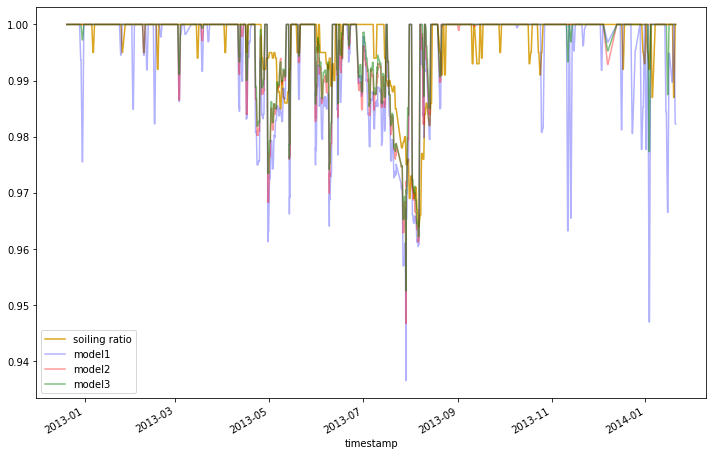

In [14]:
y_pred1 = predict(df_scaled, model1, feats, target)
y_pred2 = predict(df_scaled, model2, feats, target)
y_pred3 = predict(df_scaled, model3, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.power/y_pred1,1),0.0)
print(type(derate1))
derate1 = derate1.rolling('1D', min_periods=1,center = True).median()
derate2 = np.maximum(np.minimum(df_scaled.power/y_pred2,1),0.0)
derate2 = derate2.rolling('1D', min_periods=1, center = True).median()
derate3 = np.maximum(np.minimum(df_scaled.power/y_pred3,1),0.0)
derate3 = derate3.rolling('1D', min_periods=1, center = True).median()
ax1 = df['soiling_derate'].plot(figsize=(12,8), color = 'goldenrod',label = 'soiling ratio')
ax1.plot(derate1, color = 'blue', alpha = 0.3, label = 'model1')
ax1.plot(derate2, color = 'red', alpha = 0.4, label = 'model2')
ax1.plot(derate3, color = 'green', alpha = 0.5, label = 'model3')
plt.legend()

## Segmentation using changepoints obtained by Method 1

In [15]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 1. The user can switch from model1 to model2 or model3 by changing the assignment of variable ref_model.

In [16]:
feats = ['irradiance', 'mod_temp']
target = 'power'
ref_model = model1
slopes = []
mpe_scores = []
sign_slopes = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], ref_model, feats, target)
        diff = (df_scaled.loc[d1:d2].power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores.append(st.score_segment(df_scaled.loc[d1:d2].power, y_pred)[0])
        slopes.append(-slope)
        sign_slopes.append(np.sign(-slope))
    except:
        sign_slopes.append(np.finfo('d').min)
        slopes.append(np.finfo('d').min)
        mpe_scores.append(1)

### Compute output

In [17]:
indices = np.argsort(np.array(mpe_scores)*(np.array(sign_slopes)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes[j] > 0 and mpe_scores[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes[j]*mpe_scores[j])
        diff = ((df_scaled.loc[d1:d2].power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
                        
df_segments_output = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [18]:
df_segments_output

,Score,Starting date,Ending date
0,0.017802,2013-06-20 05:30:02,2013-08-07 17:00:02
1,0.015915,2013-08-11 05:50:02,2013-08-14 00:00:00
2,0.007641,2013-05-17 05:30:02,2013-06-10 07:15:02
3,0.000874,2014-01-09 08:25:02,2014-01-20 16:45:02


## Segmentation using changepoints obtained by Method 2

In [19]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])
# these dates are used by the deviation detection tool
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 2. One can switch from model1 to model2 or model3, by changing the assignment of variable ref_model.

In [20]:
feats = ['irradiance', 'mod_temp']
target = 'power'
ref_model = model3
slopes = []
mpe_scores = []
sign_slopes = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], ref_model, feats, target)
        diff = (df_scaled.loc[d1:d2].power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores.append(st.score_segment(df_scaled.loc[d1:d2].power, y_pred)[0])
        slopes.append(-slope)
        sign_slopes.append(np.sign(-slope))
    except:
        sign_slopes.append(np.finfo('d').min)
        slopes.append(np.finfo('d').min)
        mpe_scores.append(1)



### Compute output

In [21]:
indices = np.argsort(np.array(mpe_scores)*(np.array(sign_slopes)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes[j] > 0 and mpe_scores[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes[j]*mpe_scores[j])
        diff = ((df_scaled.loc[d1:d2].power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
        
                
df_segments_output = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [22]:
df_segments_output

,Score,Starting date,Ending date
0,0.011742,2013-06-21 05:40:02,2013-08-14 00:00:00
1,0.006444,2013-05-25 05:30:02,2013-06-10 07:15:02
